# Skin disease recognition

Dermatology is one of the most neglected areas when it comes to preventing and maintaining human health. Many people do not pay attention to changes that occur on their skin, often treating them as something harmless that they have become accustomed to, putting a visit to a specialist at the bottom of their priority list. These growths, when left untreated, can remain dormant for a long time and then, for example, after exposure to an external factor, can take on a pathological form that significantly threatens our health.

In recent years, due to technological advances, modern computer tools have been increasingly used in the diagnosis of skin diseases. One of these tools is neural networks, which are excellent at detecting patterns in images for classification purposes. This allows for the early detection of potentially dangerous skin changes and faster medical intervention. The development of technology in image recognition enables the creation of increasingly advanced systems that can help diagnose skin diseases and improve the health of patients. This paper presents the process of recognizing skin changes based on photographs and evaluates the effectiveness of machine learning algorithms in this task.

Data comes from:
*Tschandl P., Rosendahl C. & Kittler H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018)*

<img src="img/dermatolog.jpg" alt="Dermatologist" width="700">

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data gathering

### Dataset description
The dataset consists of following columns:
 - *lesion_id* - id number of particular lesion
 - *image_id* - image file name
 - *dx* - recognized lesion code, which stands for:
    - *akiec* - Actinic keratoses and intraepithelial carcinoma / Bowen's disease
    - *bcc* - basal cell carcinoma
    - *bkl* - benign keratosis-like lesions
    - *df* - dermatofibroma
    - *mel* - melanoma
    - *nv* - melanocytic nevi
    - *vasc* - vascular lesions

 - *dx_type* - defines how was the lesion was recognized:
    - *histo* - through histopathology
    - *follow-up* - follow-up examination
    - *consensus* - expert consensus
    - *confocal* - confirmation by in-vivo confocal microscopy
 - *age* - patient's age group
 - *sex* - patient's sex
 - *localization* - localization of the lesion


### Loading images metadata
Read the file with recognized lesions data

In [2]:
lesions_df = pd.read_csv('archive/HAM10000_metadata.csv')
lesions_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Loading images
I will load the images using data generator object. A data generator is an object in TensorFlow that enables easy loading of large datasets, such as images, into memory one batch at a time. In the case of large datasets, such as image datasets, loading them all at once into memory can lead to the exhaustion of memory resources, as well as prolong the time it takes to load the data.

To properly connect labels from the dataframe with photos we need to pass correct filename, which mean we must modify the *image_id* column:

In [3]:
lesions_df['image_id'] = lesions_df['image_id'] + '.jpg'
lesions_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear


For proper training/validation data split I will shuffle the dataset, so that all classes are more-less evenly distributed in those subsets.

In [6]:
lesions_df = lesions_df.sample(frac=1)

# Exploratory data analysis
Let's have a look at how the diseases are distributed

### Lession types count
Let's check how many lesions of each category are in the dataset. I will split it into two charts, where one will show distribution of distinct lesions shown in the dataset and the other will show distribution of lesions images, because some lesions have couple photos. To do it I will prepare the second dataset for them.

In [4]:
distinct_lesions_df = lesions_df.drop('image_id', axis=1).drop_duplicates()
distinct_lesions_df.head()

,lesion_id,dx,dx_type,age,sex,localization
0,HAM_0000118,bkl,histo,80.0,male,scalp
2,HAM_0002730,bkl,histo,80.0,male,scalp
4,HAM_0001466,bkl,histo,75.0,male,ear
6,HAM_0002761,bkl,histo,60.0,male,face
8,HAM_0005132,bkl,histo,70.0,female,back


Next I will prepare a DataFrame to store both counted values

In [5]:
counts_df = pd.DataFrame()
counts_df['images_count'] = lesions_df['dx'].value_counts()
counts_df['lesions_count'] = distinct_lesions_df['dx'].value_counts()
counts_df

,images_count,lesions_count
nv,6705,5403
mel,1113,616
bkl,1099,727
bcc,514,327
akiec,327,228
vasc,142,98
df,115,73


...and create a plot

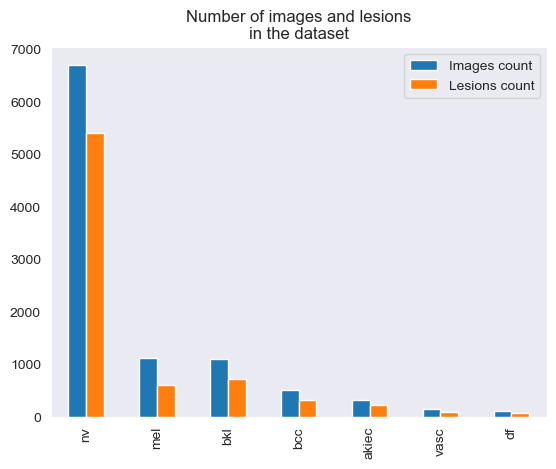

In [16]:
ax = counts_df.plot.bar()
ax.legend(labels=['Images count', 'Lesions count'])
ax.set_title('Number of images and lesions\nin the dataset')
ax.grid(False)
plt.show()

### Density plot for each lesion type vs age
Let's check how do the particular diseases appear in several age groups - this will be shown on density plot.

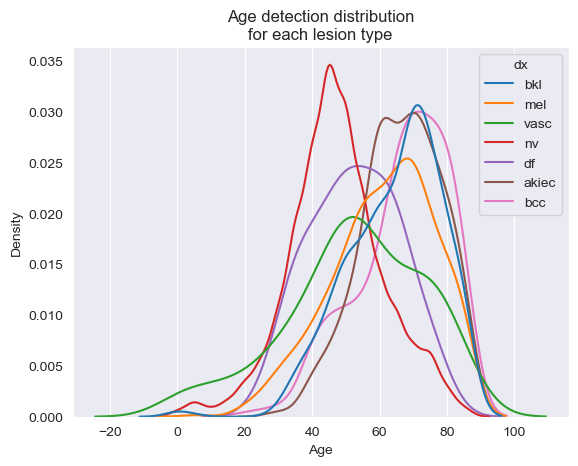

In [17]:
ax = sns.kdeplot(
    data=distinct_lesions_df,
    x='age',
    common_norm=False,
    hue='dx'
)
ax.set_title('Age detection distribution\nfor each lesion type')
ax.grid(axis='y', visible=False)
ax.set_xlabel('Age')

plt.show()

**Conclusion:** People at their forties should start to take care of melanocytic nevi disease (*nv*), while when reaching age of 50 dermatofibroma (*df*) and vascular lesions (*vasc*) most usually appear. The rest of diseases the most intensively appear after age of 60.

### Localization
Let's check the localization of each lesion. We will do it using a heatmap. We will start with creating a pivot table as an input data.

In [18]:
heatmap_table = distinct_lesions_df.pivot_table(index='dx', columns='localization', values='age', aggfunc='count').fillna(0)
heatmap_table

localization,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,unknown,upper extremity
dx,,,,,,,,,,,,,,,
akiec,3.0,0.0,22.0,9.0,2.0,84.0,0.0,0.0,8.0,41.0,8.0,8.0,1.0,0.0,42.0
bcc,9.0,0.0,123.0,32.0,0.0,61.0,2.0,0.0,1.0,36.0,11.0,11.0,6.0,3.0,32.0
bkl,36.0,0.0,133.0,50.0,4.0,194.0,1.0,1.0,12.0,109.0,20.0,24.0,57.0,10.0,67.0
df,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,54.0,0.0,0.0,0.0,0.0,14.0
mel,31.0,0.0,185.0,34.0,10.0,64.0,15.0,0.0,1.0,104.0,18.0,9.0,27.0,6.0,111.0
nv,718.0,3.0,1058.0,111.0,19.0,61.0,208.0,43.0,39.0,1224.0,60.0,24.0,1152.0,138.0,503.0
vasc,22.0,0.0,12.0,3.0,0.0,5.0,0.0,0.0,3.0,16.0,2.0,2.0,27.0,0.0,6.0


Next I will normalize these values

In [19]:
heatmap_table_normalized = heatmap_table.copy()
for i in range(len(heatmap_table_normalized)):
    heatmap_table_normalized.iloc[i] = heatmap_table_normalized.iloc[i] / heatmap_table_normalized.iloc[i].sum() * 100
heatmap_table_normalized

localization,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,unknown,upper extremity
dx,,,,,,,,,,,,,,,
akiec,1.315789,0.00000,9.649123,3.947368,0.877193,36.842105,0.000000,0.000000,3.508772,17.982456,3.508772,3.508772,0.438596,0.000000,18.421053
bcc,2.752294,0.00000,37.614679,9.785933,0.000000,18.654434,0.611621,0.000000,0.305810,11.009174,3.363914,3.363914,1.834862,0.917431,9.785933
bkl,5.013928,0.00000,18.523677,6.963788,0.557103,27.019499,0.139276,0.139276,1.671309,15.181058,2.785515,3.342618,7.938719,1.392758,9.331476
df,2.739726,0.00000,1.369863,0.000000,0.000000,0.000000,1.369863,1.369863,0.000000,73.972603,0.000000,0.000000,0.000000,0.000000,19.178082
mel,5.040650,0.00000,30.081301,5.528455,1.626016,10.406504,2.439024,0.000000,0.162602,16.910569,2.926829,1.463415,4.390244,0.975610,18.048780
nv,13.393024,0.05596,19.735124,2.070509,0.354411,1.137847,3.879873,0.802089,0.727476,22.831561,1.119194,0.447678,21.488528,2.574147,9.382578
vasc,22.448980,0.00000,12.244898,3.061224,0.000000,5.102041,0.000000,0.000000,3.061224,16.326531,2.040816,2.040816,27.551020,0.000000,6.122449


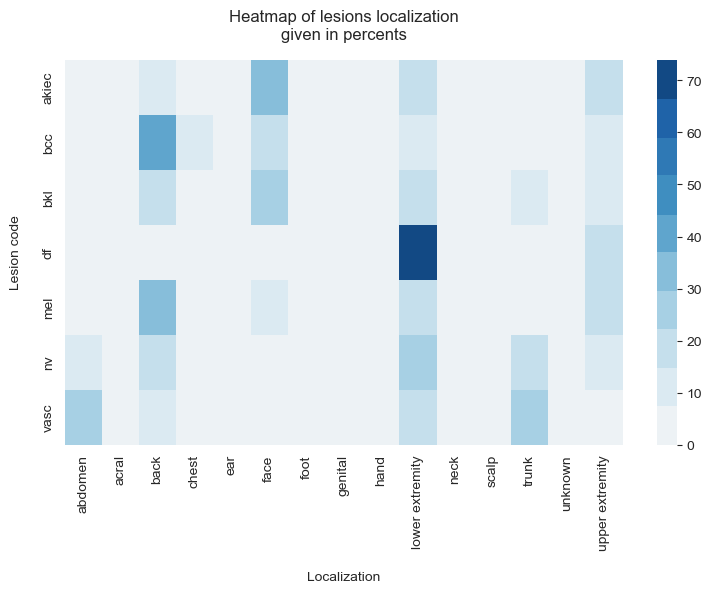

In [22]:
fig, ax = plt.subplots(figsize=(9,5), squeeze=False)

ax = sns.heatmap(
    data=heatmap_table_normalized,
    cmap=sns.color_palette('RdBu',20),
    ax=ax[0, 0],
    center=0
)
ax.set_ylabel('Lesion code', labelpad=15)
ax.set_xlabel('Localization', labelpad=15)
ax.set_title('Heatmap of lesions localization\ngiven in percents', pad=15)

plt.show()

**Conclusion:** Majority of lesions occur on lower extremity, back and face.

# Building model

First I will create an Image data generator - an object that will load the images to the model.

In [8]:
# Creating ImageDataGenerator object
img_generator = ImageDataGenerator(rescale=1. / 255)

### Splitting the data into training, validation and test sets

In [9]:
# First data split
lesions_train_df, lesions_test_df = train_test_split(lesions_df, test_size=0.1)
# Second split
lesions_train_df, lesions_valid_df = train_test_split(lesions_train_df, test_size=0.2)
print(f'Training data: {len(lesions_train_df)} elements')
print(f'Validation data: {len(lesions_valid_df)} elements')
print(f'Testing data: {len(lesions_test_df)} elements')

Training data: 7210 elements
Validation data: 1803 elements
Testing data: 1002 elements


### Outnumbered classes images augmentation
Optional TODO

Now I will create generators

In [10]:
# Images directory
img_dir = 'archive/HAM10000_images'
# Training data generator
train_generator = img_generator.flow_from_dataframe(dataframe=lesions_train_df,  # DataFrame with labels
                                                    directory=img_dir,  # images directory
                                                    x_col='image_id',  # column name containing images names
                                                    y_col='dx',  # column name containing labels
                                                    class_mode='categorical',  # classification mode
                                                    batch_size=32)
# Validation data generator
validation_generator = img_generator.flow_from_dataframe(dataframe=lesions_valid_df,
                                                         directory=img_dir,
                                                         x_col='image_id',
                                                         y_col='dx',
                                                         class_mode='categorical',
                                                         batch_size=32)
# Testing data generator
test_generator = img_generator.flow_from_dataframe(dataframe=lesions_test_df,
                                                    directory=img_dir,
                                                    x_col='image_id',
                                                    y_col='dx',
                                                    class_mode='categorical',
                                                    batch_size=32)

Found 7210 validated image filenames belonging to 7 classes.
Found 1803 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.


### Check how the data has been split
We have to check if the data has been spit evenly into both - training and testing - sets.

In [11]:
# Counts values
index_train, counts_train = np.unique(train_generator.classes, return_counts=True)
index_valid, counts_valid = np.unique(validation_generator.classes, return_counts=True)
index_test, counts_test = np.unique(test_generator.classes, return_counts=True)
# Create DataFrame
split_counts_df = pd.DataFrame(index=train_generator.class_indices.keys())
split_counts_df['Training'] = counts_train
split_counts_df['Validation'] = counts_valid
split_counts_df['Testing'] = counts_test
# Show the DataFrame
split_counts_df

,Training,Validation,Testing
akiec,234,67,26
bcc,375,94,45
bkl,789,190,120
df,83,24,8
mel,775,222,116
nv,4853,1187,665
vasc,101,19,22


Now let's show it on the plot

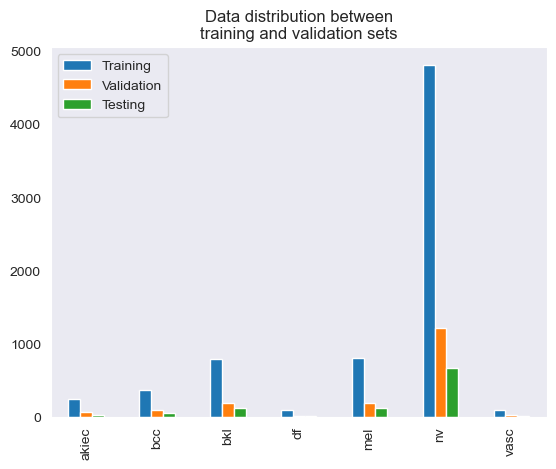

In [11]:
ax = split_counts_df.plot.bar()
ax.grid(False)
ax.set_title('Data distribution between\ntraining and validation sets')

plt.show()

**Conclusion:** The data has been split evenly, so in both datasets there will be similar samples distribution.

### Model architecture
Below the model architecture is defined. It uses a series of convolutional layers with increasing numbers of filters (32, 64, and 128), followed by max pooling layers to downsample the feature maps. The use of multiple convolutional layers allows the network to learn increasingly complex features from the images, while the max pooling layers reduce the spatial dimensions of the feature maps, allowing the network to focus on the most important features. The final dense layers use a softmax activation function to produce probability scores for each class. Additionally, the architecture includes a flatten layer that converts the 2D feature maps to a 1D feature vector, which is necessary for passing the features to the dense layers.

In [12]:
model_1 = keras.Sequential([layers.Conv2D(32, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(64, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(128, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Flatten(),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(7, activation='softmax')
])

In [13]:
model_2 = keras.Sequential([layers.Conv2D(32, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(64, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(128, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Flatten(),
                            layers.Dropout(0.25),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(7, activation='softmax')
])

In [14]:
model_3 = keras.Sequential([layers.Conv2D(16, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(32, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(64, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(128, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Flatten(),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(7, activation='softmax')
])

### Model class weights
As one class outnumbers others I will add weights to the classes to equalize their input to the loss function. This tells the algorithm to "pay more attention" to samples from an under-represented class.

In [20]:
# Get classes to predict during training
classes_train = train_generator.classes
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(classes_train), y=classes_train)
# Print it
class_weights_dict = dict(zip(range(7), class_weights))
for key in class_weights_dict:
    print(f'{key} -> {class_weights_dict[key]}')

0 -> 4.401709401709402
1 -> 2.7466666666666666
2 -> 1.3054499366286438
3 -> 12.409638554216867
4 -> 1.3290322580645162
5 -> 0.21223985163816197
6 -> 10.198019801980198


We can see that class with index 5, which outnumbers other classes has the lowest weight.

### Model class weights - manual version
Below I am setting manually classes weights, only to limit the impact of the most numerous class and to strengthen two the rarest ones.

In [15]:
class_weights_manual = dict()
for i in range(6):
    class_weights_manual[i] = 1

class_weights_manual[3] = 3
class_weights_manual[5] = 0.75
class_weights_manual[6] = 3

for key in class_weights_manual:
    print(f'{key} -> {class_weights_manual[key]}')

0 -> 1
1 -> 1
2 -> 1
3 -> 3
4 -> 1
5 -> 0.75
6 -> 3


### Model compilation
Model compilation is responsible for configuring it for training by specifying the optimizer, loss function, and metrics to be used during the training process. The optimizer determines how the model is updated based on the loss function and gradients calculated during training, while the loss function is used to measure the error between the predicted output and the actual output. Metrics are used to evaluate the performance of the model during training and can be used to monitor the progress of the training process.

optional TODO: choose parameters for non-even data distribution as 'accuracy' is good for evenly distributed classes

In [16]:
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

In [17]:
model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

In [18]:
model_3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

### Training multiple models
In this stage I am training multiple models with various parameters to check which one will bring the best results for 10 epochs. This model will be trained on more epochs to get the best training.

In [35]:
models_dict = {'model_1': model_1, 'model_2': model_2, 'model_3': model_3}
weights_dict = {'None': None, 'computed': class_weights_dict, 'manual': class_weights_manual}

In [ ]:
# Create empty DF
model_results_columns = ['model', 'weights', 'loss', 'accuracy', 'val_loss', 'val_accuracy']
models_results_df = pd.DataFrame(columns=model_results_columns)

# Iterate models
for multi_model in models_dict:
    # Iterate model classes weights
    for multi_weights in weights_dict:
        # Fit model
        history = models_dict[multi_model].fit(train_generator,
                                               epochs=10,
                                               validation_data=validation_generator,
                                               class_weight=weights_dict[multi_weights]
                                               )
        # Create DataFrame with results from this iteration
        models_results_iter = pd.DataFrame([[multi_model,
                                             multi_weights,
                                             history.history['loss'],
                                             history.history['accuracy'],
                                             history.history['val_loss'],
                                             history.history['val_accuracy'],
                                           ]],
                                           columns=model_results_columns
                                           )
        # Concatenate it with the main DataFrame
        models_results_df = pd.concat([models_results_df,
                                       models_results_iter
                                       ])

# Save results to .csv file
models_results_df.to_csv('test_results.csv', index=False)

In [40]:
models_results_df.head()

,model,weights,loss,accuracy,val_loss,val_accuracy
0,model_1,None,"[0.6700233817100525, 0.6330018043518066, 0.591...","[0.7481275796890259, 0.7595006823539734, 0.778...","[0.7870102524757385, 0.7809263467788696, 0.819...","[0.7054908275604248, 0.7104825377464294, 0.718..."
0,model_1,computed,"[1.1113598346710205, 0.7850975394248962, 0.672...","[0.6622745990753174, 0.6966713070869446, 0.739...","[1.2246404886245728, 1.4165431261062622, 1.404...","[0.6123127937316895, 0.5973377823829651, 0.638..."
0,model_1,manual,"[0.09706204384565353, 0.07332593202590942, 0.0...","[0.9596393704414368, 0.9718446731567383, 0.975...","[2.2071797847747803, 2.686591386795044, 2.6180...","[0.6866334080696106, 0.6927343606948853, 0.683..."
0,model_2,None,"[0.8856620192527771, 0.8417119383811951, 0.757...","[0.687656044960022, 0.6976421475410461, 0.7224...","[0.8704584836959839, 0.8063642382621765, 0.767...","[0.6727676391601562, 0.701608419418335, 0.7077..."
0,model_2,computed,"[1.192742943763733, 1.0348783731460571, 0.7072...","[0.611511766910553, 0.6396671533584595, 0.7238...","[2.34169602394104, 2.10721492767334, 1.9803913...","[0.4914032220840454, 0.5091513991355896, 0.439..."


Define a function to create performance plot of initial training

In [163]:
def plot_initial_results(parameter, title):

    fig_f, ax_f = plt.subplots(ncols=3, figsize=(18,5))
    fig_f.suptitle(title, fontsize=15)
    models_names_list = sorted(models_results_df['model'].unique())
    weights_names_list = sorted(models_results_df['weights'].unique())

    for model_number, model_name in enumerate(models_names_list):
        for weights_name in weights_names_list:
            for result in models_results_df.loc[(models_results_df['model']==model_name) &
                                                (models_results_df['weights']==weights_name),
                                                parameter
                                               ]:
                sns.lineplot(y=result,
                             x=range(1, len(result)+1),
                             ax=ax_f[model_number],
                             label=weights_name
                            )
                ax_f[model_number].set_xlabel('Epochs')
                ax_f[model_number].set_title(model_name)
                ax_f[model_number].legend()

    plt.show()

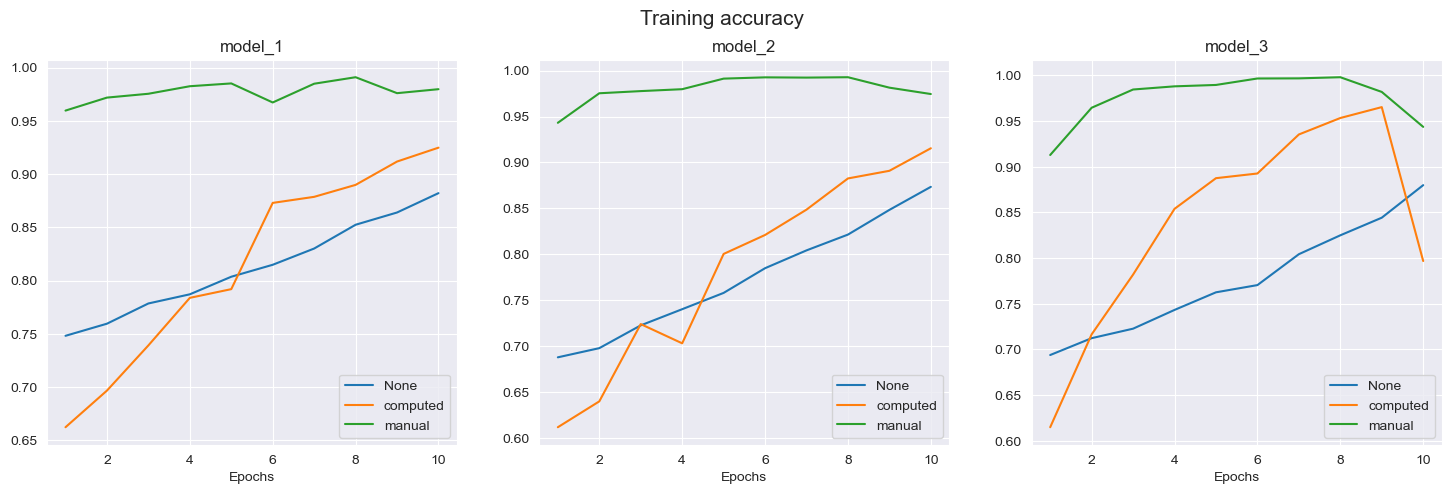

In [169]:
# Create accuracy plot
plot_initial_results('accuracy', 'Training accuracy')

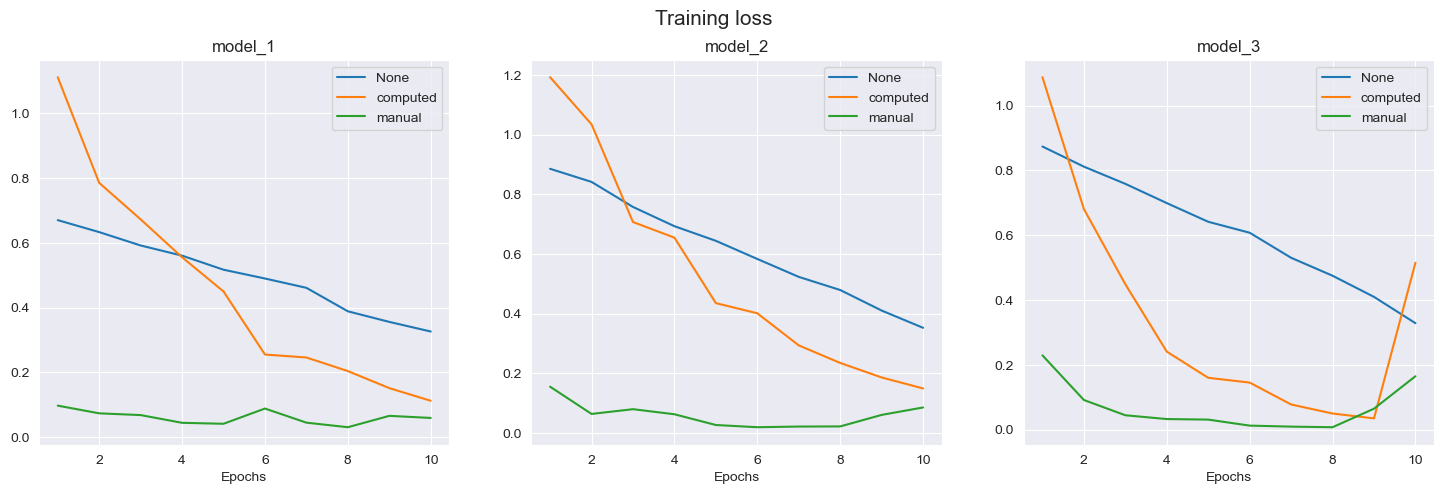

In [170]:
# Create loss plot
plot_initial_results('loss', 'Training loss')

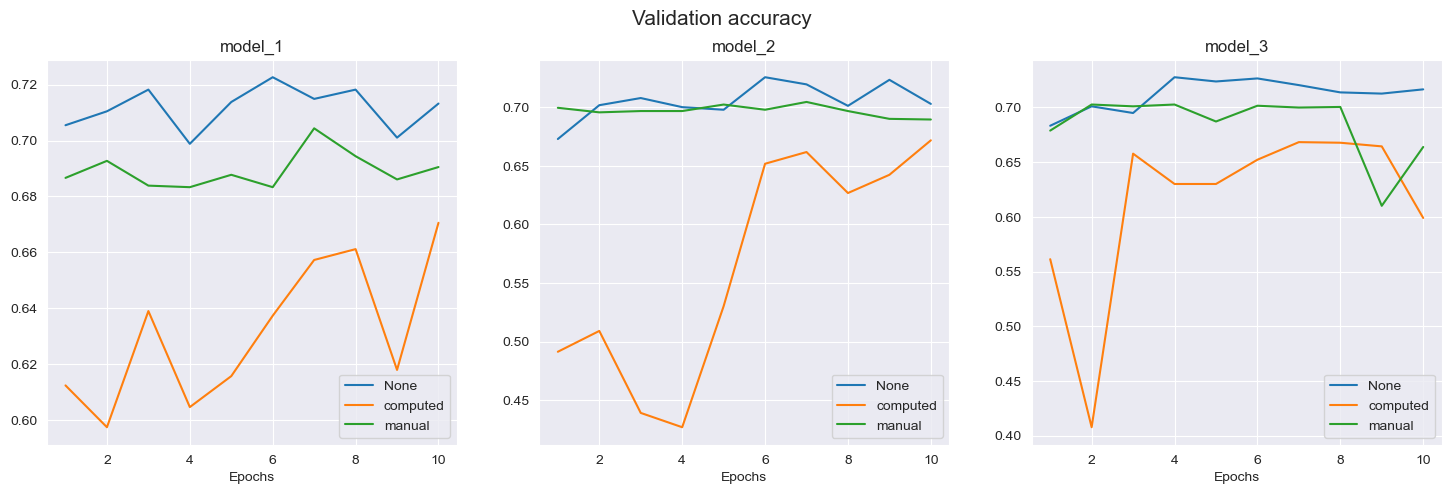

In [171]:
# Create validation accuracy plot
plot_initial_results('val_accuracy', 'Validation accuracy')

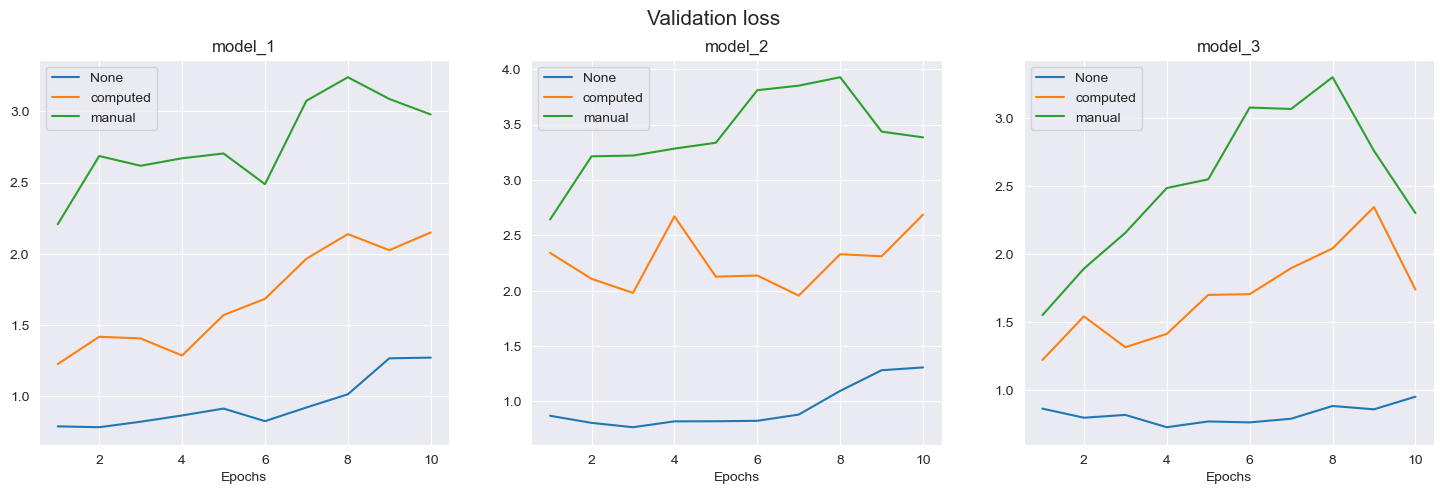

In [172]:
# Create validation loss plot
plot_initial_results('val_loss', 'Validation loss')

**Conclusion:** We can see the best performance of model XXX because

Best model architecture

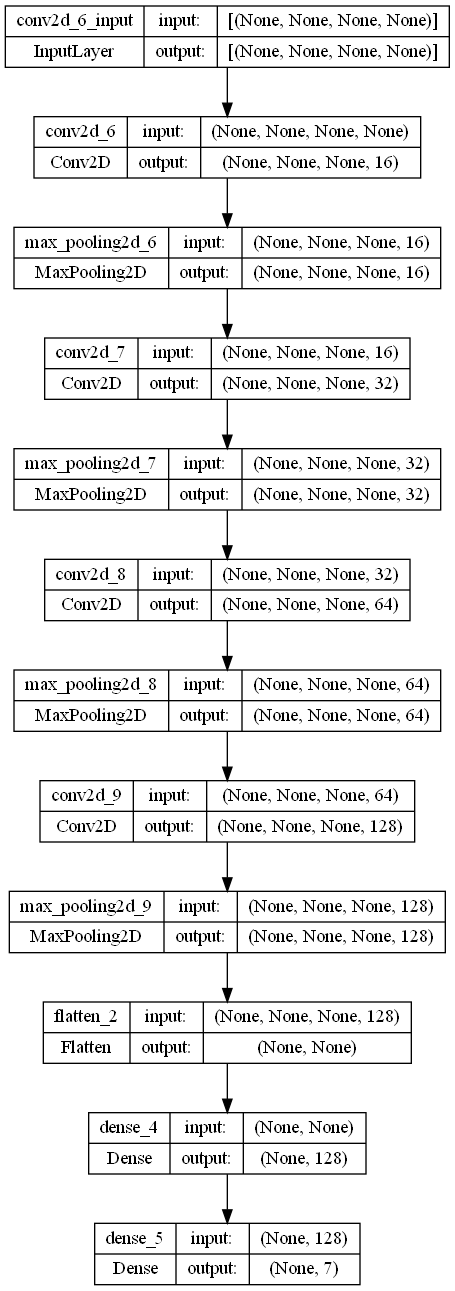

In [173]:
plot_model(model_3, show_shapes=True, show_layer_names=True)

=========================================
=========================================

### Training the model with more epochs
For further training I will take "XXXXX" model with XXXXX classes weights and 50 epochs. I will also define a callback to save model configuration with the best results.

In [174]:
callback = keras.callbacks.ModelCheckpoint(filepath='model_3_callback.h5',
                                           monitor='val_acc',
                                           mode='max',
                                           verbose=1)

In [175]:
history_3 = model_3.fit(train_generator,
                        epochs=30,
                        validation_data=validation_generator,
                        class_weight=None,
                        callbacks=callback
)

Epoch 1/30
226/226 [==============================] - ETA: 0s - loss: 0.0500 - accuracy: 0.9828
Epoch 1: saving model to model_3_callback.h5
226/226 [==============================] - 207s 914ms/step - loss: 0.0500 - accuracy: 0.9828 - val_loss: 2.5035 - val_accuracy: 0.6994
Epoch 2/30
226/226 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9906
Epoch 2: saving model to model_3_callback.h5
226/226 [==============================] - 149s 657ms/step - loss: 0.0337 - accuracy: 0.9906 - val_loss: 3.1488 - val_accuracy: 0.6999
Epoch 3/30
226/226 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9971
Epoch 3: saving model to model_3_callback.h5
226/226 [==============================] - 148s 653ms/step - loss: 0.0112 - accuracy: 0.9971 - val_loss: 3.1544 - val_accuracy: 0.6983
Epoch 4/30
226/226 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9796
Epoch 4: saving model to model_3_callback.h5
226/226 [======================

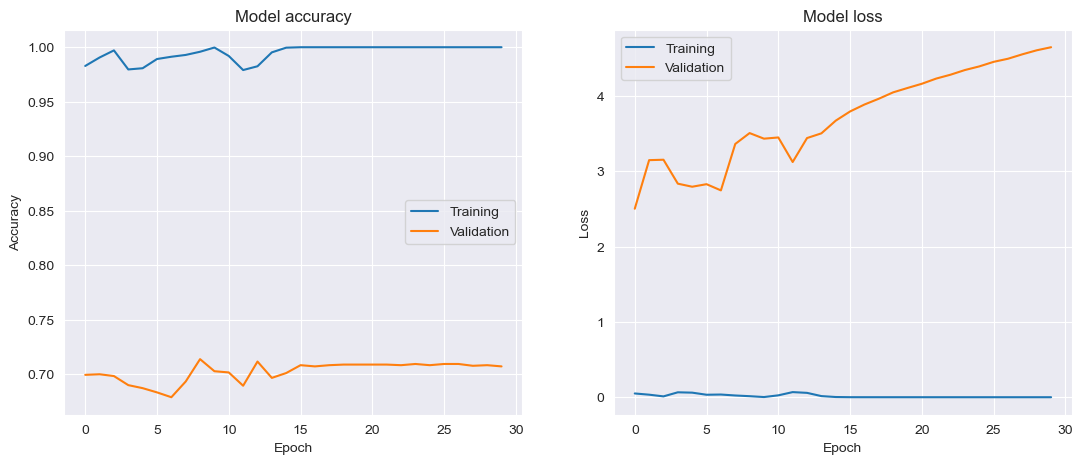

In [187]:
fig, ax = plt.subplots(ncols=2, figsize=(13,5))

ax[0].plot(history_3.history['accuracy'])
ax[0].plot(history_3.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training', 'Validation'])

ax[1].plot(history_3.history['loss'])
ax[1].plot(history_3.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training', 'Validation'])

plt.show()

### Model evaluation
Now let's check how the model acts on testing data

In [ ]:
model_3.evaluate(test_generator)

In [ ]:
predicted = model_3.predict(test_generator)

Confusion matrix shows outcome of real vs predicted values - we can see for which lesions the model works the worst.

In [ ]:
predicted_values = np.argmax(predicted, axis=1)
true_values = test_generator.classes
confusion_mtx_01 = confusion_matrix(true_values, predicted_values)
confusion_mtx_01

**Conclusion:**

Lets calculate other metrics: F1 score, recall and precision
### TODO

# Transfer learning
### TODO